In [2]:
### 04/22 update
### fix rms error in real space, and plot leakage vs. k_in

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
import scipy.optimize as opt
import scipy.interpolate as interp
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from mycolorpy import colorlist as mcp
%run Fraunhofer
%run ErrMask

In [3]:
def filter_annulus_amp(screen, A, k_in, k_out): 
    """
    k_in, k_out: filter radius in the fourier space
    A = amplitude of the amplitude error mask
    Modify screen['E']
    Return filtered WN in real space
    """
    N = screen['N']
    k = screen['kap'] # radius in k space
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    screen['E'] = (1 + A*WN_fil) * screen['E']
    #return(A*WN_fil) #return amplitude in real space
    return(A*WN_fil, WN_FT_fil)

In [22]:
### fix error amplitude (scaling factor)
### iterate different k_in, fix dk
### plot rms vs. k_in
### fit a line a*x+b
### want a constant rms: given k_in, read the corresponding rms, then scale it to the expected rms

N_screen = 1024
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option = 'amp'
radius = 2.0
amp = 0.1
k_in = np.arange(0,50,5)
dk = 2
k_out = k_in+dk
RMS = np.array([])
RMS_sq = np.array([])

for i in range(len(k_in)):

    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    center = (screen1['D']/2, screen1['D']/2)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)

    if option=='phase':
        (emap_E, emap_k) = filter_annulus_phase(screen1, amp, k_in[i], k_out[i]) ### scaled error map in real space
    elif option=='amp':
        (emap_E, emap_k) = filter_annulus_amp(screen1, amp, k_in[i], k_out[i])
    norm_k = np.abs(emap_k**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<k_out[i]) & (screen1['kap']>k_in[i])) # inside the filter
    avg_fft = np.mean(norm_k[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_k)*screen1['dk']**2
    rms_sq = np.abs(rms(emap_E)**2) #rms square
    rms_nosq = rms(emap_E) # rms
#     print(total_Vf)
#     print('rms = ', rms_sq)
    RMS_sq = np.append(RMS_sq, rms_sq)
    RMS = np.append(RMS, rms_nosq)
    


area of annulus in k space is 
$A = \pi(k_{out}^2-k_{in}^2) = \pi((k_{in}+r)^2-k_{in}^2) = \pi(k_{in}^2+2k_{in}r+r^2-k_{in}^2) = \pi(2k_{in}r+r^2)$, where $r$ is the width of the annulus

so area in k space $\propto$ $k_{in}$; total power $\propto$ area; so total power $\propto$ $k_{in}$;

rms $\propto$ sqrt of power, therefore $\propto$ $k_{in}$.


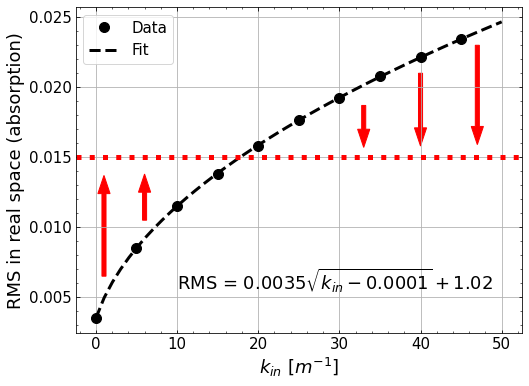

In [28]:
### fit lines of leakage vs. k_in

def linear(x, k, b):
    return(k*x+b)
def sqrt(x, k, b, c):
    return(k*np.sqrt(x+c)+b)
(fit1, err1) = opt.curve_fit(linear, k_in, RMS_sq, absolute_sigma=True)
(fit2, err2) = opt.curve_fit(sqrt, k_in, RMS,absolute_sigma=True)

RMS_want = 0.05
#spline
sp = interp.InterpolatedUnivariateSpline(k_in, sqrt(k_in, fit2[0], fit2[1], fit2[2]))
sp_scale = interp.InterpolatedUnivariateSpline(k_in, RMS_want*(amp/sqrt(k_in, fit2[0], fit2[1], fit2[2])))
fig = plt.figure(figsize=(8,6))
k_plot = np.linspace(0,50,50)
plt.plot(k_in, RMS, 'o', ms=10, color='black', label='Data')
plt.plot(k_plot, sqrt(k_plot, fit2[0], fit2[1], fit2[2]),'--', lw=3, label='Fit', color='black')
#plt.plot(k_plot, sp(k_plot), '--', lw=3, color='black')
plt.xlabel(r'$k_{in}$ $\left[m^{-1}\right]$', fontsize=18)
plt.ylabel('RMS in real space (absorption)', fontsize=18)
plt.text(10, 0.0055, r'RMS = $0.0035\sqrt{k_{in}-0.0001}+1.02$', color='black', fontsize=18)
plt.axhline(0.015, ls=':', lw=5, color='red')
plt.grid()
plt.legend()
plt.arrow(1, 0.0065, 0, 0.0059, head_width = 1.5, width=0.5, head_length=0.0013, color='red')
plt.arrow(6, 0.0105, 0, 0.002, head_width = 1.5, width=0.5, head_length=0.0013, color='red')
plt.arrow(33, 0.0187, 0, -0.0017, head_width = 1.5, width=0.5, head_length=0.0013, color='red')
plt.arrow(40, 0.021, 0, -0.0039, head_width = 1.5, width=0.5, head_length=0.0013, color='red')
plt.arrow(47, 0.023, 0, -0.0058, head_width = 1.5, width=0.5, head_length=0.0013, color='red')


plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/rms_fit_h.png', bbox_inches='tight', dpi=600)

In [158]:
### fix error amplitude (scaling factor)
### iterate through different k_in, fix dk
### plot rms vs. k_in
### sqrt fit of rms vs. k_in
### want a constant rms: given k_in, calculate the corresponding rms, then scale it to the expected constant rms level

RMS = np.array([])
scaling = np.array([]) # scaling factor of error masks 
RMS_test = np.array([])

for i in range(len(k_in)):

    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    center = (screen1['D']/2, screen1['D']/2)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)

    if option=='phase':
        (emap_E, emap_k) = filter_annulus_phase(screen1, amp, k_in[i], k_out[i]) ### scaled error map in real space
    elif option=='amp':
        (emap_E, emap_k) = filter_annulus_amp(screen1, amp, k_in[i], k_out[i])
    RMS = np.append(RMS, rms(emap_E))
    rms_fit = sqrt(k_in[i], fit2[0], fit2[1], fit2[2])
    scaling = np.append(scaling, RMS_want/rms_fit)

    ### recreate scaled error mask and measure the scaled rms to make sure it all equals to the RMS_want
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    center = (screen1['D']/2, screen1['D']/2)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)

    if option=='phase':
        (emap_E, emap_k) = filter_annulus_phase(screen1, sp_scale(k_in[i]), k_in[i], k_out[i]) ### ignore emap_k, not scaled properly; only interested in emap_E
    elif option=='amp':
        (emap_E, emap_k) = filter_annulus_amp(screen1, sp_scale(k_in[i]), k_in[i], k_out[i])
    rms_test = rms(emap_E)
    RMS_test = np.append(RMS_test, rms_test)


Text(0, 0.5, 'Scaling factor')

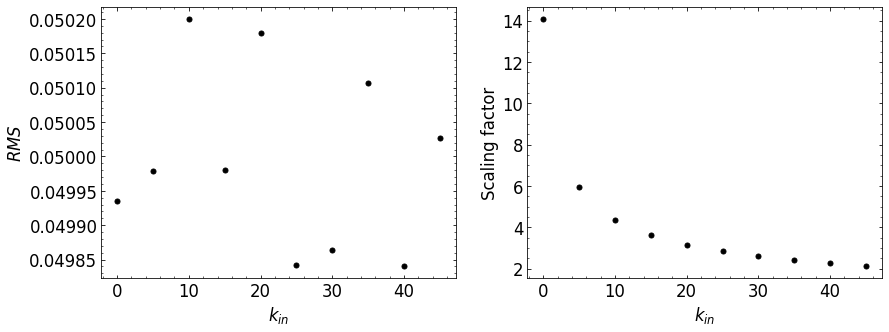

In [159]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(k_in, RMS_test, 'o', ms=5, color='black')
plt.xlabel(r'$k_{in}$')
plt.ylabel(r'$RMS$')
plt.subplot(1,2,2)
plt.plot(k_in, scaling, 'o', ms=5, color='black')
plt.xlabel(r'$k_{in}$')
plt.ylabel('Scaling factor')

# read csv files generated by BEAM_leakVSk_RMSfix.py
## plot leakage vs. k_in for fixed rms errors

Text(0.5, 1.0, 'RMS')

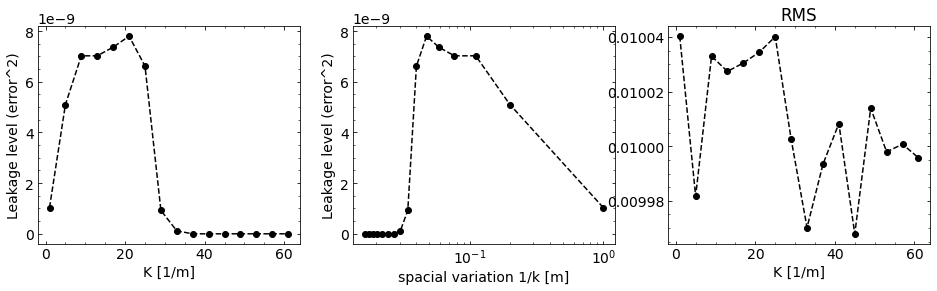

In [166]:
# phase
(k, leak, scale, rms_test) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/RMS0.01_leak_k_phase.csv', usecols=(0,1,2,3), unpack=True)
fig = plt.figure(figsize=(16,4))
plt.rcParams['font.size'] = 14
plt.subplot(1,3,1)
plt.plot(k,leak,'o--', color='black')
plt.ylabel('Leakage level (error^2)')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel('K [1/m]')
plt.subplot(1,3,2)
plt.semilogx(1/k,leak,'o--', color='black')
plt.ylabel('Leakage level (error^2)')
plt.xlabel('spacial variation 1/k [m]')
plt.subplot(1,3,3)
plt.plot(k,rms_test,'o--', color='black')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel('K [1/m]')
plt.title('RMS')

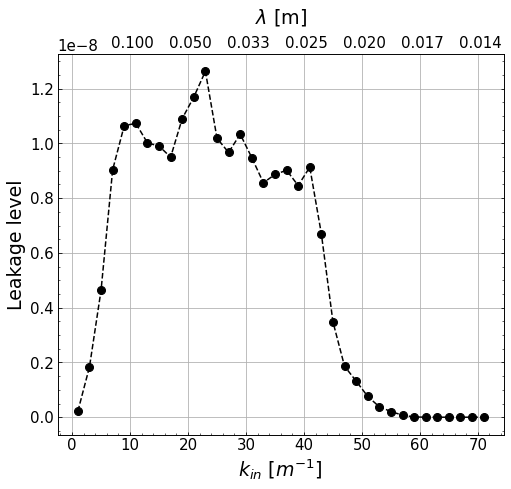

In [60]:
# amplitude
(k, leak, scale, rms_test) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/RMS0.01_leak_k_amp.csv', usecols=(0,1,2,3), unpack=True)
x = 1/k
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#xlabel = [1.000, 0.083, 0.042, 0.027, 0.020, 0.016]
#ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(xlabel))
ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 1.35e-8, '0.100')
plt.text(0.25, 1.35e-8, '0.050')
plt.text(0.38, 1.35e-8, '0.033')
plt.text(0.51, 1.35e-8, '0.025')
plt.text(0.64, 1.35e-8, '0.020')
plt.text(0.77, 1.35e-8, '0.017')
plt.text(0.9, 1.35e-8, '0.014')


# ax3 = fig.add_subplot(1,2,2)
# ax4 = ax3.twiny()
# ax4.set_xticks([])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
# ax3.plot(k,rms_test,'o', color='black')
# #plt.xlabel('spacial variation 1/k [m]')
# ax3.set_xlabel(r'$k_{in}$ [$\frac{1}{m}$]')
# ax3.set_ylabel('RMS')
# ax3.grid()
# ax4.xaxis.set_label_coords(.5, 1.15)
# ax4.set_xlabel('$\lambda$ [m]')
# plt.text(0.13, 1.0065e-2, '0.100')
# plt.text(0.28, 1.0065e-2, '0.050')
# plt.text(0.42, 1.0065e-2, '0.033')
# plt.text(0.565, 1.0065e-2, '0.025')
# plt.text(0.713, 1.0065e-2, '0.020')
# plt.text(0.872, 1.0065e-2, '0.017')

#plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/leak_k_fixx.png', bbox_inches='tight' )
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/RMS_fix_amp_h.png', bbox_inches='tight', dpi=600)

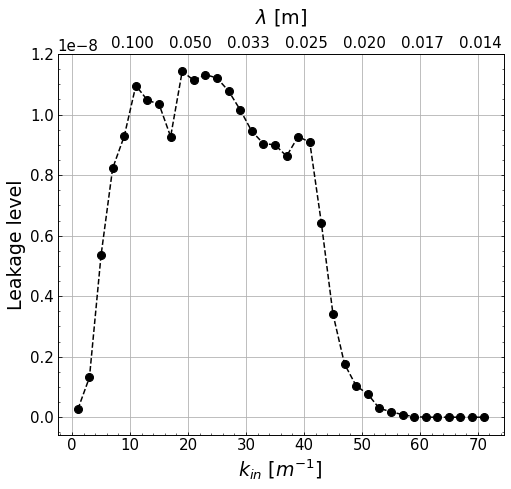

In [63]:
# phase
(k, leak, scale, rms_test) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/RMS0.01_leak_k_phase.csv', usecols=(0,1,2,3), unpack=True)
x = 1/k
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#xlabel = [1.000, 0.083, 0.042, 0.027, 0.020, 0.016]
#ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(xlabel))
ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 1.22e-8, '0.100')
plt.text(0.25, 1.22e-8, '0.050')
plt.text(0.38, 1.22e-8, '0.033')
plt.text(0.51, 1.22e-8, '0.025')
plt.text(0.64, 1.22e-8, '0.020')
plt.text(0.77, 1.22e-8, '0.017')
plt.text(0.9, 1.22e-8, '0.014')

plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/RMS_fix_phase_h.png', bbox_inches='tight', dpi=600)

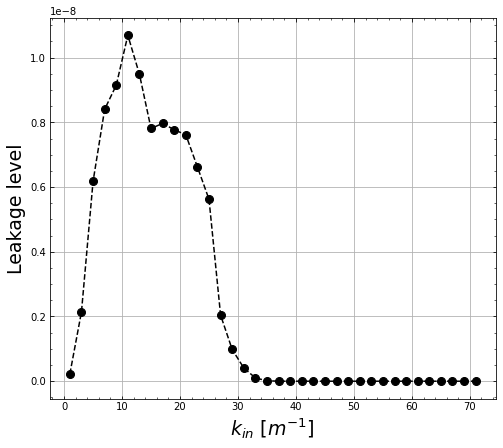

In [6]:
### some test...
(k, leak, scale, rms_test) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/test.csv', usecols=(0,1,2,3), unpack=True)
x = 1/k
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(1,1,1)
#ax2 = ax1.twiny()
#ax2.set_xticks([])
ax1.plot(k,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#xlabel = [1.000, 0.083, 0.042, 0.027, 0.020, 0.016]
#ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(xlabel))
# ax2.xaxis.set_label_coords(.5, 1.08)
# ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
# plt.text(0.12, 1.22e-8, '0.100')
# plt.text(0.25, 1.22e-8, '0.050')
# plt.text(0.38, 1.22e-8, '0.033')
# plt.text(0.51, 1.22e-8, '0.025')
# plt.text(0.64, 1.22e-8, '0.020')
# plt.text(0.77, 1.22e-8, '0.017')
# plt.text(0.9, 1.22e-8, '0.014')


# fix k_in, vary dk

but this doesn't make sense because we are fixing RMS..... some tests...

Text(0, 0.5, 'RMS in real space')

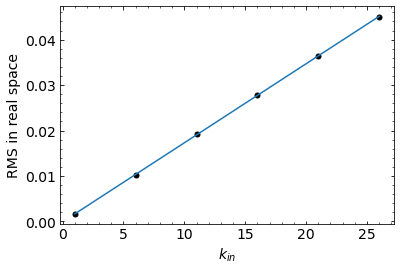

In [177]:
### fix error amplitude (scaling factor)
### iterate different k_in, fix dk
### plot rms vs. k_in
### fit a line a*x+b
### want a constant rms: given k_in, read the corresponding rms, then scale it to the expected rms

N_screen = 1024
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 4.0
trunc = 'y'
option = 'amp'
radius = 2.0

kin = 0
amp = 0.1 # need to pick amp each time 
dk = np.arange(1,30,5)
RMS = np.array([])
RMS_sq = np.array([])
RMS_test = np.array([])

for i in range(len(dk)):

    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    center = (screen1['D']/2, screen1['D']/2)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)

    if option=='phase':
        (emap_E, emap_k) = filter_annulus_phase(screen1, amp, kin, kin+dk[i]) ### scaled error map in real space
    elif option=='amp':
        (emap_E, emap_k) = filter_annulus_amp(screen1, amp, kin, kin+dk[i])
    rms_sq = np.abs(rms(emap_E)**2) #rms square
    rms_nosq = rms(emap_E) # rms
#     print(total_Vf)
#     print('rms = ', rms_sq)
    RMS_sq = np.append(RMS_sq, rms_sq)
    RMS = np.append(RMS, rms_nosq)
    
def linear(x, k, b):
    return(k*x+b)
(fit, err) = opt.curve_fit(linear, dk, RMS,absolute_sigma=True)

RMS_want = 0.05
#spline
sp_scale = interp.InterpolatedUnivariateSpline(dk, RMS_want*(amp/linear(dk, fit[0], fit[1]))) 
plt.plot(dk, RMS, 'o', ms=5, color='black', label='data')
plt.plot(dk, linear(dk, fit[0], fit[1]), label='fit')
plt.xlabel(r'$k_{in}$')
plt.ylabel('RMS in real space')


Text(0.5, 1.0, 'RMS')

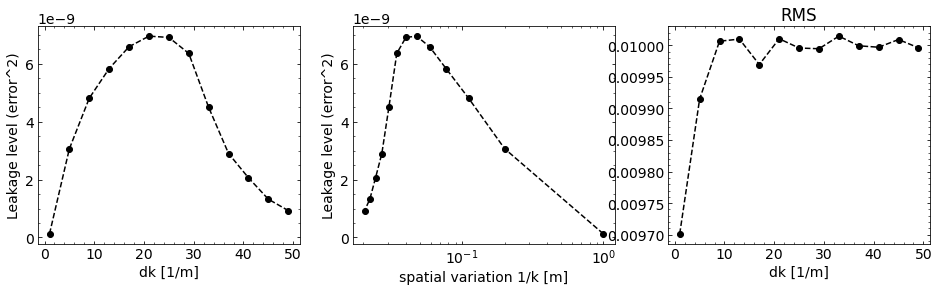

In [178]:
# k_in=0; amplitude errors, vary dk from 0 to 50
### but this is not quite meaningful... 
(dk, leak, scale, rms_test) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/test.csv', unpack=True, usecols=(0,1,2,3))
fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(dk,leak,'o--', color='black')
plt.ylabel('Leakage level (error^2)')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel('dk [1/m]')
plt.subplot(1,3,2)
plt.semilogx(1/dk,leak,'o--', color='black')
plt.ylabel('Leakage level (error^2)')
plt.xlabel('spatial variation 1/k [m]')
plt.subplot(1,3,3)
plt.plot(dk,rms_test,'o--', color='black')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel('dk [1/m]')
plt.title('RMS')

# 04/24 use a single error mask 
not really helpful... 

In [ ]:
def filter_annulus_amp(screen, A, k_in, k_out): 
    """
    k_in, k_out: filter radius in the fourier space
    A = amplitude of the amplitude error mask
    Modify screen['E']
    Return filtered WN in real space
    """
    N = screen['N']
    k = screen['kap'] # radius in k space
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    screen['E'] = (1 + A*WN_fil) * screen['E']
    #return(A*WN_fil) #return amplitude in real space
    return(A*WN_fil, WN_FT_fil)

1.0000142486621628
49.43480054573772


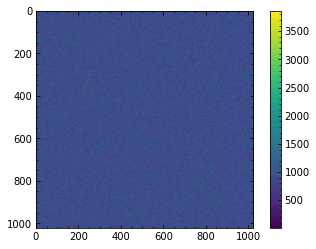

In [13]:
### fix error amplitude (scaling factor)
### iterate different k_in, fix dk, using the same white noise map in the real space
### plot rms vs. k_in
### fit a line a*x+b
### want a constant rms: given k_in, read the corresponding rms, then scale it to the expected rms


N_screen = 1024
D = 10.0
sigma = 1.0
maxdeg = 4.0
trunc = 'y'
option = 'amp'
radius = 2.0

screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, sigma)
if trunc=='y':
    InCircle(screen1, center, 2.0)

WN = np.random.normal(0,1,(N_screen,N_screen)) # fix this error map
WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN))) # also fix this error map

plt.imshow(np.abs(WN_FT))
plt.colorbar()
print(np.sqrt(np.mean(WN**2)))
print(np.abs(np.sqrt(np.mean(WN_FT**2))))

In [26]:
amp = 1.0
k_in = np.arange(1, 50, 4)
#k_in = 10
dk = 2
k_out = k_in+dk
RMS = np.array([])
RMS_sq = np.array([])

k = screen1['kap']
for i in range(len(k_in)):
    cut1 = np.where(k<k_in[i], 0, 1)
    cut2 = np.where(k>k_out[i], 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    emap_E = amp*WN_fil
    rms_sq = np.abs(rms(emap_E)**2) #rms square
    rms_nosq = rms(emap_E) # rms
    RMS_sq = np.append(RMS_sq, rms_sq)
    RMS = np.append(RMS, rms_nosq)
    print(RMS[i])
#     plt.imshow(emap_E)
#     plt.colorbar()
#     plt.show()


0.048641654904190555
0.08491762749701653
0.1093467313200514
0.1299301946131631
0.14545118386021516
0.16364044800054744
0.1767802714413341
0.18890598066613154
0.20182831960629768
0.21403184970898909
0.2245878362245359
0.23505901914322197
0.244586649222552


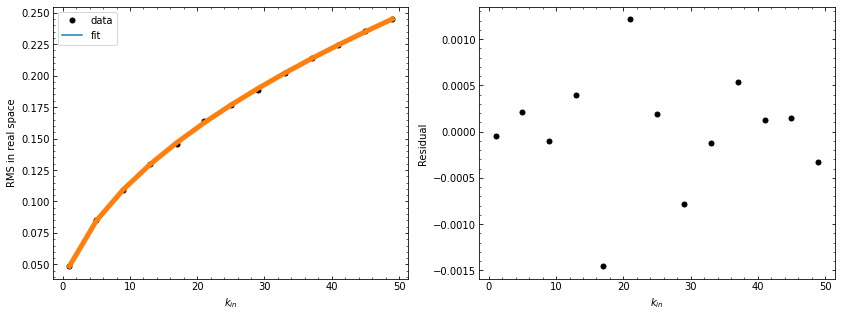

In [29]:
def sqrt(x, k, b, c):
    return(k*np.sqrt(x+c)+b)
(fit, err) = opt.curve_fit(sqrt, k_in, RMS, absolute_sigma=True)

RMS_want = 0.05
#spline
sp = interp.InterpolatedUnivariateSpline(k_in, sqrt(k_in, fit[0], fit[1], fit[2]))
sp_scale = interp.InterpolatedUnivariateSpline(k_in, RMS_want*(amp/sqrt(k_in, fit[0], fit[1], fit[2])))
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(k_in, RMS, 'o', ms=5, color='black', label='data')
plt.plot(k_in, sqrt(k_in, fit[0], fit[1], fit[2]), label='fit')
plt.plot(k_in, sp(k_in), lw=5)
plt.xlabel(r'$k_{in}$')
plt.ylabel('RMS in real space')
plt.legend()
plt.subplot(1,2,2)
plt.plot(k_in, RMS - sqrt(k_in, fit[0], fit[1], fit[2]), 'o', ms=5, color='black', label='data')
plt.xlabel(r'$k_{in}$')
plt.ylabel('Residual ')
plt.show()

In [30]:
### want a constant rms: given k_in, read the corresponding rms, then scale it to the expected rms
### fix error amplitude (scaling factor)
### iterate different k_in, fix dk
### plot rms vs. k_in
### fit a line a*x+b
### want a constant rms: given k_in, read the corresponding rms, then scale it to the expected rms

#RMS = np.array([])
RMS = np.array([])
scaling = np.array([])
RMS_test = np.array([])

for i in range(len(k_in)):
    cut1 = np.where(k<k_in[i], 0, 1)
    cut2 = np.where(k>k_out[i], 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    emap_E = sp_scale(k_in[i]) * WN_fil # new error map generated and scaled to fix the rms in real space
    rms_sq = np.abs(rms(emap_E)**2) #rms square
    rms_nosq = rms(emap_E) # rms
    RMS_sq = np.append(RMS_sq, rms_sq)
    RMS = np.append(RMS, rms_nosq)
    print(RMS[i])
    
#     rms_fit = sqrt(k_in[i], fit2[0], fit2[1], fit2[2])
#     scaling = np.append(scaling, RMS_want/rms_fit)

#     ### recreate scaled error mask and measure the scaled rms to make sure it all equals to the RMS_want

#     rms_test = rms(emap_E)
#     RMS_test = np.append(RMS_test, rms_test)


0.04995137204520577
0.05012337747208322
0.04995520184795832
0.05015178484201346
0.04950535922714918
0.05037437563934312
0.05005542392089164
0.049793321388559256
0.049970744628416434
0.050124532077473756
0.050028581139632655
0.05003214596236329
0.04993379866217765


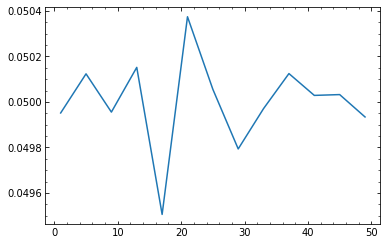

In [31]:
plt.plot(k_in, RMS)

In [10]:
k_lam = 1/0.002
np.arcsin(np.pi/180)*

17.45417873758517

In [11]:
#delta z = lambda * phi / (4pi)
0.002*0.015/(4*np.pi)

2.3873241463784303e-06